In [1]:
import pandas as pd

import re
import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopwords_eng = stopwords.words("english")

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from autocorrect import Speller
spell = Speller()

In [2]:
df = pd.read_csv('../DATASET/new_data.csv')

In [3]:
df.head()

,title,Published_on,News_agency,URL,summary,Country,language,tag
0,UN agency pauses Gaza food aid deliveries afte...,"Wed, 21 Feb 2024 15:57:00 GMT",The Guardian,https://news.google.com/rss/articles/CBMicWh0d...,UN agency pauses Gaza food aid deliveries afte...,US,en,WORLD
1,Latest Israel-Hamas war news and Gaza conflict...,"Wed, 21 Feb 2024 14:42:17 GMT",The Washington Post,https://news.google.com/rss/articles/CBMiVWh0d...,Latest Israel-Hamas war news and Gaza conflict...,US,en,WORLD
2,Israel Gaza: China condemns US veto of call fo...,"Wed, 21 Feb 2024 12:51:40 GMT",BBC.com,https://news.google.com/rss/articles/CBMiM2h0d...,Israel Gaza: China condemns US veto of call fo...,US,en,WORLD
3,Navalny’s mother goes to court over officials’...,"Wed, 21 Feb 2024 12:48:00 GMT",The Hill,https://news.google.com/rss/articles/CBMiXGh0d...,Navalny’s mother goes to court over officials’...,US,en,WORLD
4,Police fire tear gas on Indian farmers marchin...,"Wed, 21 Feb 2024 11:43:00 GMT",Reuters India,https://news.google.com/rss/articles/CBMia2h0d...,Police fire tear gas on Indian farmers marchin...,US,en,WORLD


In [4]:
df.shape

(6393, 8)

In [5]:
df.columns

Index(['title', 'Published_on', 'News_agency', 'URL', 'summary', 'Country',
       'language', 'tag'],
      dtype='object')

In [6]:
df.describe()

,title,Published_on,News_agency,URL,summary,Country,language,tag
count,6393,6393,6393,6393,6393,6393,6393,6393
unique,2866,2557,951,2864,3041,13,1,8
top,Firefly Aerospace's Alpha rocket put a satelli...,"Wed, 21 Feb 2024 09:00:00 GMT",BBC.com,https://news.google.com/rss/articles/CBMiU2h0d...,Ukraine war: Dozens of Russian troops 'die in ...,AU,en,HEALTH
freq,12,39,231,12,10,518,6393,900


In [7]:
df.isnull().sum()

title           0
Published_on    0
News_agency     0
URL             0
summary         0
Country         0
language        0
tag             0
dtype: int64

In [8]:
df.dtypes

title           object
Published_on    object
News_agency     object
URL             object
summary         object
Country         object
language        object
tag             object
dtype: object

In [9]:
df['published_date'] = pd.to_datetime(df['Published_on'])

In [10]:
df['published_year'] = df['published_date'].dt.year

In [11]:
df['published_year'].unique()

array([2024, 2023, 2022], dtype=int32)

In [12]:
df['published_year'].value_counts()

published_year
2024    6300
2023      92
2022       1
Name: count, dtype: int64

In [13]:
df['published_year'].value_counts(normalize=True)*100

published_year
2024    98.545284
2023     1.439074
2022     0.015642
Name: proportion, dtype: float64

In [14]:
df['published_month'] = df['published_date'].dt.month

In [15]:
df['published_month'].value_counts(normalize=True)*100

published_month
2     97.997810
1      0.547474
12     0.437979
11     0.234632
9      0.218990
10     0.203347
6      0.109495
8      0.109495
7      0.062568
5      0.031284
3      0.031284
4      0.015642
Name: proportion, dtype: float64

In [16]:
df['published_month'].nunique()

12

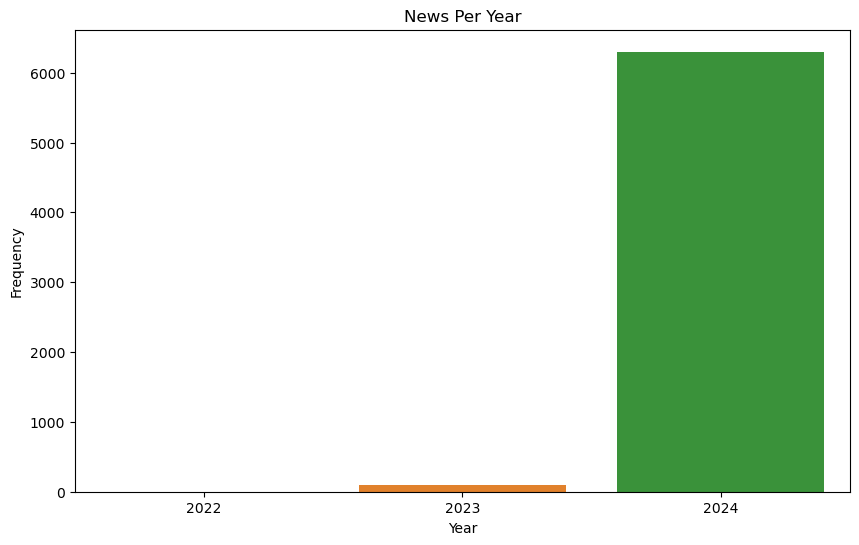

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='published_year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('News Per Year')
plt.show()

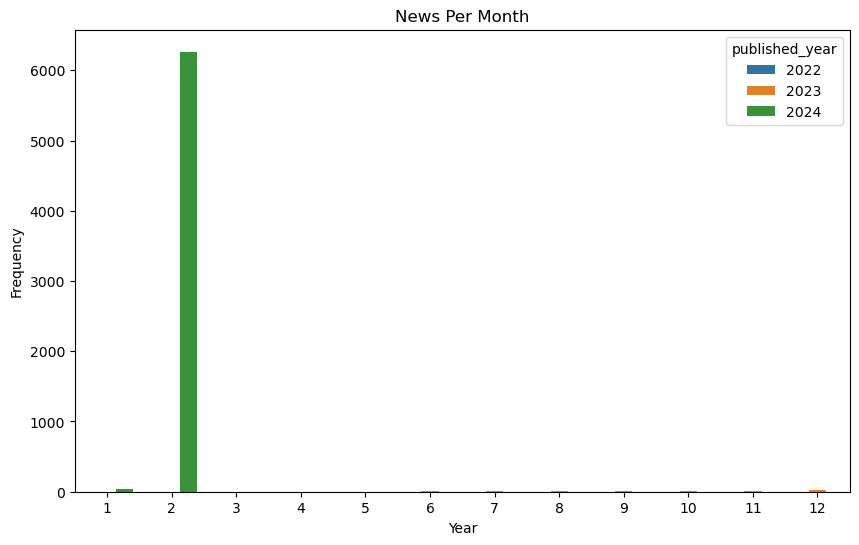

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='published_month', hue='published_year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('News Per Month')
plt.show()

In [19]:
df.Country.nunique()

13

In [20]:
df.Country.value_counts(normalize=True)*100

Country
AU    8.102612
IN    7.930549
DE    7.789770
FR    7.789770
RU    7.789770
CN    7.774128
BR    7.774128
ES    7.758486
IT    7.742844
JP    7.742844
US    7.602065
CA    7.539496
GB    6.663538
Name: proportion, dtype: float64

In [21]:
df.language.value_counts(normalize=True)*100

language
en    100.0
Name: proportion, dtype: float64

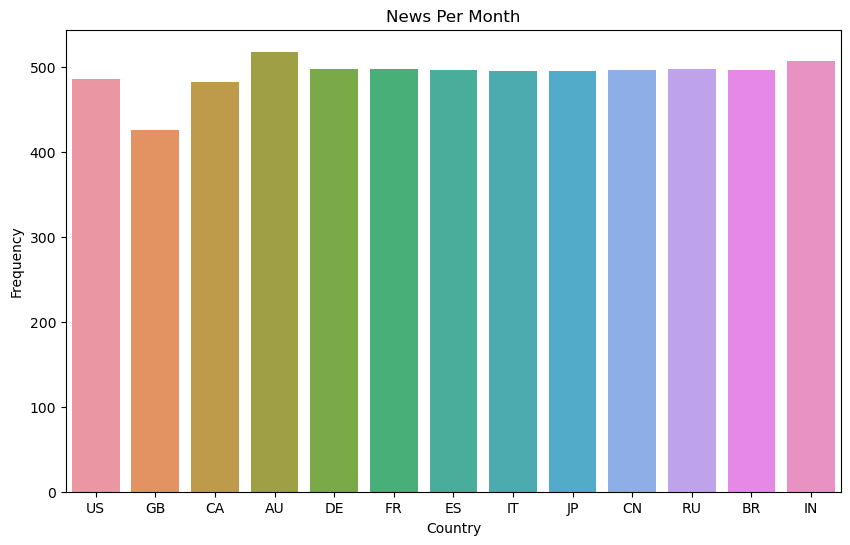

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Country')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.title('News Per Month')
plt.show()

In [23]:
df.tag.nunique()

8

In [24]:
df.tag.value_counts(normalize=True)*100

tag
HEALTH           14.077898
NATION           13.436571
SPORTS           13.405287
BUSINESS         13.139371
TECHNOLOGY       11.888003
SCIENCE          11.684655
WORLD            11.356171
ENTERTAINMENT    11.012044
Name: proportion, dtype: float64

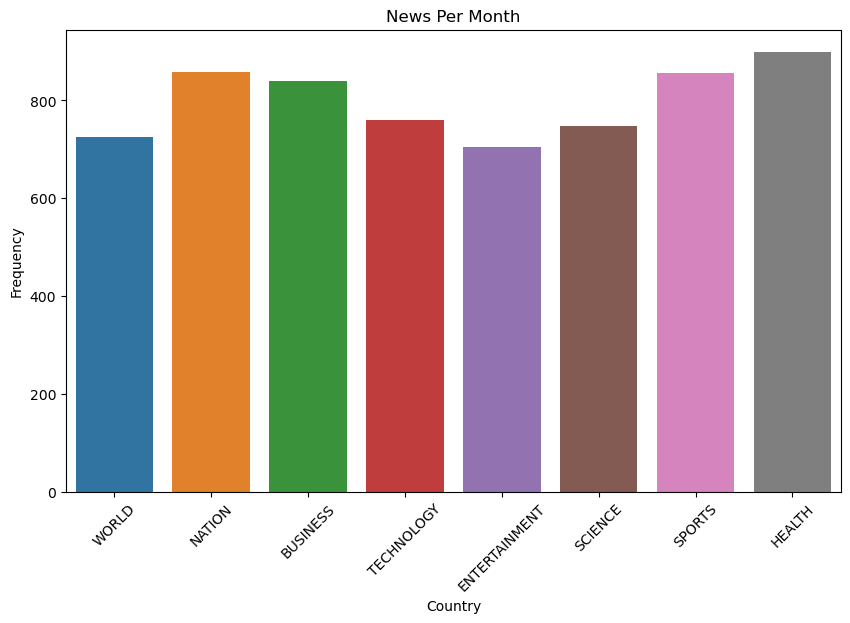

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='tag')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('News Per Month')
plt.show()

In [26]:
def clean_text(text): 
    for agency in df['News_agency'].unique():
        agency = re.sub(r'\(|\)|\|', '', agency)
        text = re.sub(r'\(|\)|\|', '', text)
        text = re.sub(rf'{agency}', ' ', text)
    return re.sub(r'[^\w\s]', '', text)

In [27]:
def regex_spell_len_fix(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

In [28]:
def remove_whitespace(text): 
    return text.strip()

In [29]:
def convert_to_lowercase(text): 
    return text.lower()

In [30]:
def remove_punctuation(text): 
    return text.translate(str.maketrans('', '', string.punctuation))

In [31]:
def tokenize(text): 
    return word_tokenize(text)

In [32]:
def fix_spell(token):
    return spell(token)

In [33]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stopwords_eng]

In [34]:
lem = WordNetLemmatizer()
def lemmatization(tokens):
    return [lem.lemmatize(word) for word in tokens]

In [35]:
def preprocess_pipeline(text): 
    text = clean_text(text)
    text = regex_spell_len_fix(text)
    text = fix_spell(text)
    text = remove_whitespace(text)
    text = convert_to_lowercase(text)
    text = remove_punctuation(text)
    tokens = tokenize(text)
    tokens = remove_stop_words(tokens)
    return lemmatization(tokens)

In [ ]:
df['preprocessed_tokens'] = df['summary'].apply(preprocess_pipeline)

In [ ]:
df.head()

In [ ]:
def join_tokens(tokens): 
    return ' '.join(tokens)

In [ ]:
df['clean_text'] = df['preprocessed_tokens'].apply(join_tokens)

In [ ]:
text = ' '.join(df['clean_text'])

plt.figure(figsize = (20,20))

wordcloud = WordCloud(max_words = 100 , width = 1000 , height = 1000 , background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
vectorizer_bow = CountVectorizer()

X_bow = vectorizer_bow.fit_transform(df['clean_text'])

feature_names_bow = vectorizer_bow.get_feature_names_out()

count_word_freq = dict(zip(feature_names_bow, X_bow.toarray().sum(axis=0)))

wordcloud_bow = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(count_word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_bow, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Bag of Words (BoW)')
plt.show()

In [ ]:
vectorizer_tfidf = TfidfVectorizer()

X_tfidf = vectorizer_tfidf.fit_transform(df['clean_text'])

feature_names_tfidf = vectorizer_tfidf.get_feature_names_out()

tfidf_word_freq = dict(zip(feature_names_tfidf, X_tfidf.toarray().sum(axis=0)))

wordcloud_tfidf = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_tfidf, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - TF-IDF')
plt.show()


In [ ]:
df.to_csv('../DATASET/preprocessed/preprocessed_news.csv')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier



from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df['clean_text'], df.tag, test_size=0.3, random_state=42,stratify=df['tag'])

In [ ]:
def display_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    disp.plot(xticks_rotation='vertical')
    plt.show()

In [ ]:
def calculate_scores(model):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print("accuracy for Training Set:", round(accuracy_score(y_train, pred_train)*100,2), "\b%")
    print("Classification Report for Training Set:\n\n", classification_report(y_train, pred_train))
    display_confusion_matrix(y_train, pred_train, model.classes_)
    print()
    print("accuracy for Test Set:", round(accuracy_score(y_test, pred_test)*100,2), "\b%")
    print("Classification Report for Test Set:\n\n", classification_report(y_test, pred_test))
    display_confusion_matrix(y_test, pred_test, model.classes_)

In [ ]:
# combining two different vectorization method 
rfc = Pipeline([('vect', CountVectorizer()),
                 ('model', RandomForestClassifier(n_estimators=1000,
                                                  criterion="gini"))])

rfc_model = rfc.fit(X_train, y_train)
calculate_scores(rfc_model)

In [ ]:
# using TFidf vectorization method 
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # TF-IDF vectorizer
    ('classifier', RandomForestClassifier(random_state=42))  # Example classifier
])

rfc_tfidf_model = tfidf_pipeline.fit(X_train, y_train)
calculate_scores(rfc_tfidf_model)

In [ ]:
lr = Pipeline([('vect', CountVectorizer()),
               ('model', LogisticRegression(penalty='l2',
                                            C=1,
                                            solver='saga',
                                            multi_class='multinomial',
                                            max_iter=1000,
                                            class_weight='balanced'))])

lr_model = lr.fit(X_train, y_train)

calculate_scores(lr_model)

In [ ]:
lr = Pipeline([('tfidf', TfidfVectorizer()),
               ('model', LogisticRegression(penalty='l2',
                                            C=1,
                                            solver='saga',
                                            multi_class='multinomial',
                                            max_iter=1000,
                                            class_weight='balanced'))])

lr_model = lr.fit(X_train, y_train)
calculate_scores(lr_model)

In [ ]:
sv = Pipeline([('vect', CountVectorizer()),
               ('model', svm.SVC(kernel='linear',
                                 C=1.0,
                                 max_iter=5000))])

sv_model = sv.fit(X_train, y_train)

calculate_scores(sv_model)

In [ ]:
sv = Pipeline([('tfidf', TfidfVectorizer()),
               ('model', svm.SVC(kernel='linear',
                                 C=1.0,
                                 max_iter=5000))])

sv_model = sv.fit(X_train, y_train)

calculate_scores(sv_model)

In [ ]:
test = '''

ERS-2, a vintage satellite launched in 1995, is expected to re-enter Earth’s atmosphere today before landing in the ocean.

Scientists are currently tracking the course of the decommissioned satellite, expecting most of it to burn up during re-entry.

While the satellite will break up around 80km above Earth, there’s a chance that some of the satellite's fragments will also crash into the ocean.

However, the European Space Agency (ESA) isn’t concerned, reminding people that there’s just a one in 100 billion chance of a human being injured by space debris.

'''
preprocessed_text = preprocess_pipeline(test)
print(' '.join(preprocessed_text))

In [ ]:
sv_pred = sv_model.predict([' '.join(preprocessed_text)])

In [ ]:
sv_pred